In [1]:
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig, AutoModelForSeq2SeqLM, AutoConfig, BartTokenizerFast

'''
T5 계열 중 사용 가능한 모델 예시
- csebuetnlp/mT5_multilingual_XLSum > (4.4GB이상) train epoch=16, inference epoch=8 추천 
- eenzeenee/t5-base-korean-summarization > (1.1GB이상) train epoch=24, inference epoch=16 추천  (한국어 깨짐)

위에 두 T5 모델은 <class 'transformers.models.t5.tokenization_t5_fast.T5TokenizerFast'>
                <class 'transformers.models.mt5.modeling_mt5.MT5ForConditionalGeneration'>

- paust/pko-flan-t5-large > (1.64GB) train epoch = 16, inference epoch = 8
- (max encoder len = 512...) KETI-AIR/ke-t5-large-ko > (5.9GB) train epoch = 8, inference epoch = 8
<class 'transformers.models.t5.tokenization_t5_fast.T5TokenizerFast'>
<class 'transformers.models.t5.modeling_t5.T5ForConditionalGeneration'>

...

BART 계열 중 사용 가능한 모델 예시
- EbanLee/kobart-summary-v3 > (474MB) train epoch=200, inference epoch=32 추천 
- digit82/kobart-summarization > (947MB) train epoch=200, inference epoch=32 추천 
- cosmoquester/bart-ko-base > (971MB) train epoch=200, inference epoch=32 추천 

- alaggung/bart-r3f > (187MB) train epoch=256, inference epoch=64
...

Longformer & BART hybrid 계열
- [x] MikaSie/LexLM_Longformer_BART_hybrid_V1 > (1.63GB) 
'''

model_name = "digit82/kobart-summarization"

tokenizer = AutoTokenizer.from_pretrained(model_name, legacy=False)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

### model이 BartForConditionalGeneration 이면 gradient checkpointing kwargs에 use_cache 파라미터를 사용할 수 없다.
if "BartForConditionalGeneration" in str(model.__class__):
    gradient_checkpointing_kwargs = {"use_reentrant": False}
else:
    gradient_checkpointing_kwargs = {"use_reentrant": False, 'use_cache': False}

print(tokenizer.__class__)
print(model.__class__)

You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


<class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>
<class 'transformers.models.bart.modeling_bart.BartForConditionalGeneration'>


In [2]:
print(tokenizer.tokenize("안녕 안녕한데 안녕하세요 반가워요"))
print(tokenizer.tokenize("Mr. Smith"))

['▁안녕', '▁안녕', '한데', '▁안녕', '하세요', '▁반가', '워', '요']
['▁M', 'r', '.', '▁S', 'm', 'i', 'th']


- ⚠️ config의 inference/remove_tokens에는 Special_token을 추가하지 전에 토크나이저가 기본적으로 갖고 있는 special tokens를 설정해줘야 한다.

In [3]:
import collections.abc
def flatten(l):
    for el in l:
        if isinstance(el, collections.abc.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
try:
    remove_tokens = list(flatten(tokenizer.special_tokens_map.values()))
    remove_tokens.append("<usr>")
except:
    remove_tokens = []
print(remove_tokens)

['<s>', '</s>', '<unk>', '<pad>', '<mask>', '<usr>']


- ⚠️ 만약 bos_token이 None이라면 토크나이저에 맞는 처리를 해야 한다.
    - T5 계열 모델의 토크나이저는 bos_token을 사용하지 않는다. 그냥 None으로 놔두면 된다.

In [4]:
print(f'''
    PAD token id : {tokenizer.pad_token_id},
    BOS token id : {tokenizer.bos_token_id},
    BOS : {tokenizer.bos_token},
    EOS : {tokenizer.eos_token},
    PAD : {tokenizer.pad_token},
    SEP : {tokenizer.sep_token if tokenizer.sep_token else "None is SEP token"},
    Special_tokens : {tokenizer.special_tokens_map},
    Tokenizer's max_model_input_sizes : {tokenizer.model_max_length}
''')


    PAD token id : 3,
    BOS token id : 0,
    BOS : <s>,
    EOS : </s>,
    PAD : <pad>,
    SEP : None is SEP token,
    Special_tokens : {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'mask_token': '<mask>'},
    Tokenizer's max_model_input_sizes : 1000000000000000019884624838656



In [5]:
# 모델의 구성 정보를 YAML 파일로 저장합니다.
project_dir = "/data/ephemeral/home/nlp-5/auto1p/"
import os
import sys
sys.path.append(
    project_dir
)
from src.utils.utils import *

In [6]:
current_time = get_current_time()
concept = "bart" # 실험 컨셉을 작성. output 디렉토리 이름 및 config 파일 이름 설정 시 반영됨.
output_dir = f"./outputs/exp_{concept}_{current_time}"
print(current_time)

08040747


Processing train_df...


100%|██████████| 12457/12457 [00:09<00:00, 1326.78it/s]



Processing val_df...


100%|██████████| 499/499 [00:00<00:00, 1714.39it/s]



Processing test_df...


100%|██████████| 499/499 [00:00<00:00, 1004.79it/s]


train dialogue 최대 토큰 길이: 	1079
validation dialogue 최대 토큰 길이: 	670
test dialogue 최대 토큰 길이: 	1245



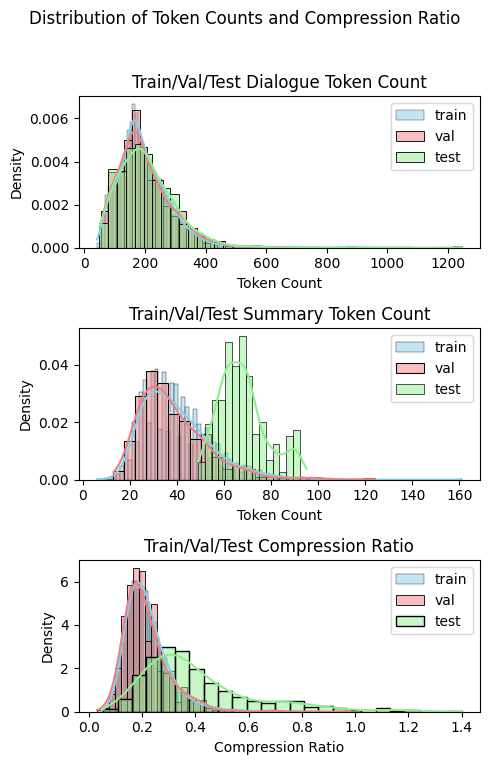

You passed `num_labels=3` which is incompatible to the `id2label` map of length `2`.


False


/data/ephemeral/home/nlp-5/auto1p/src/utils/eda_length.py:88: UserWarning: ⚠️  입력한 인코더 길이(1245)가 모델의 최대 길이(1026)를 초과합니다.
  warnings.warn(


In [7]:
from src.utils.eda_length import *
recommend_max_encoder_length = eda_length(project_dir, tokenizer, model)
print(validate_model_enc_length(recommend_max_encoder_length, model_name))

In [ ]:
save_eval_log_steps = 100 # save_step은 eval, log step의 배수여야 한다. 같이 맞춰주는 것이 편하다.
train_batch_size = 256
inference_batch_size = 64 # eval batch size 도 동일하게 설정됨
'''
mT5 계열 모델은 모델의 최대 길이를 파악할 수 있는 방법이 없다. 일단 recommend_max_encoder_length으로 설정하고 오류가 나면 줄여야 한다.
'''
encoder_max_len = 1026 # 모델의 encoder input length 보다는 작게 설정해야 함. (확인하는 방법이 모델마다 다름;;)
decoder_max_len = 200 # inference max length 도 동일하게 설정

In [ ]:
config_data = {
    "general": {
        "data_path": "./data/", # 모델 생성에 필요한 데이터 경로를 사용자 환경에 맞게 지정합니다.
        "model_name": model_name, # 불러올 모델의 이름을 사용자 환경에 맞게 지정할 수 있습니다.
        "output_dir": output_dir, # 모델의 최종 출력 값을 저장할 경로를 설정합니다.
        "train_data": ["train_clean_special_tokens.csv", "ai_hub_02daily_15532_cleaned.csv"], # 학습 데이터 파일을 설정한다. data_path 폴더 안에 존재해야 한다.
        "val_data": "dev.csv",
        "test_data": "test.csv", # 추론 데이터 파일을 설정한다. 추론 데이터에 topic이나 ner을 추가할 경우에 대비.
    },
    "tokenizer": {
        "encoder_max_len": encoder_max_len,
        "decoder_max_len": decoder_max_len,
        "bos_token": f"{tokenizer.bos_token}",
        "eos_token": f"{tokenizer.eos_token}",
        "sep_token": f"{tokenizer.sep_token}",
        # 특정 단어들이 분해되어 tokenization이 수행되지 않도록 special_tokens을 지정해줍니다.
        "special_tokens": [ '#Person1#', '#Person2#', '#Person3#', '#Person4#',
            '#Person5#', '#Person6#', '#Person7#',
            '#PhoneNumber#', '#Address#', '#DateOfBirth#','#PassportNumber#','#SSN#','#CardNumber#','#CarNumber#','#Email#',
            '#Topic#','#Dialogue#', # Topic, Dialogue special token을 사용할 때는 test_data를 test_topic_solar.csv로 사용해야 한다.
        ]
    },
    "training": {
        "seed": 42,
        "output_dir": output_dir,
        "overwrite_output_dir": False,

        "save_total_limit": 1,
        "load_best_model_at_end": True,
        "save_steps": save_eval_log_steps,

        "logging_dir": output_dir,
        "logging_steps": save_eval_log_steps,

        "num_train_epochs": 50,
        "per_device_train_batch_size": train_batch_size,
        "remove_unused_columns": True,
        "fp16": False, # float16 사용 메모리 절약, But 정밀도 문제 존재 > 구형 GPU에서 사용
        "bf16": True, # float16 사용 메모리 절약, 정밀도 문제 개선 > 30/40,... 등 최신 GPU 가능
        "dataloader_drop_last": False,
        "group_by_length": True,
        
        "gradient_checkpointing": True,
        
        "gradient_checkpointing_kwargs": gradient_checkpointing_kwargs,
        "gradient_accumulation_steps": 1,
        "torch_empty_cache_steps": 1,
        "dataloader_num_workers": 8,

        "per_device_eval_batch_size": inference_batch_size,
        "evaluation_strategy": 'steps',
        "eval_steps": save_eval_log_steps,
        
        "predict_with_generate": True,
        "generation_max_length": decoder_max_len,
        
        # Callbacks
        "early_stopping_patience": 2,
        "early_stopping_threshold": 0.001,

        # Optimizer
        "learning_rate": 1e-5,
        "warmup_steps": 10,
        "weight_decay": 1e-3,
        "num_cycles": 1,

        "report_to": "none", # 학습 과정을 어느 백엔드에 저장할 것인지. "none" 설정 시 wandb 미사용. "wandb" 설정 시 사용.

        # PEFT
        "LoRA": False,
        "QLoRA": False,
    },
    # (선택) wandb 홈페이지에 가입하여 얻은 정보를 기반으로 작성합니다.
    "wandb": {
        "entity": "skiersong", # 팀 실험 시 organization 이름
        "project": "nlp-5-upgrade",
        "name": f"a_{concept}_{current_time}", # 개별 실험 이름
        "group": concept, # 유사한 실험들은 같은 그룹으로 설정
        "notes": "AutoModel baseline", # 실험에 대한 추가 설명
    },
    "inference": {
        "ckt_dir": os.path.join(output_dir, 'best'), # 파인튜닝이 진행된 모델의 checkpoint를 저장할 경로를 설정합니다.
        "result_path": os.path.join(output_dir, f"submission_{current_time}.csv"), # 제출할 csv 파일 저장 경로
        "no_repeat_ngram_size": 2, # 
        "early_stopping": True,
        "generate_max_length": decoder_max_len,
        "num_beams": 5,
        "batch_size" : inference_batch_size,
        # 정확한 모델 평가를 위해 제거할 불필요한 생성 토큰들을 정의합니다.
        "remove_tokens": remove_tokens,
        "length_penalty": 1.2 # > 1로 설정하면 짧은 문장을 선호하도록 페널티를 강화, 1보다 작은 값을 주면 긴 생성문을 선호하게 된다.
    }
}

In [11]:
import os
import yaml
from pprint import pprint

config_path = os.path.join(
    project_dir,'src','configs',
    f"config_{concept}_{current_time}.yaml" # config 파일 이름을 설정
)
with open(config_path, "w") as file:
    yaml.dump(config_data, file, allow_unicode=True)

with open(config_path, "r") as file:
    loaded_config = yaml.safe_load(file)

# 불러온 config 파일의 전체 내용을 확인합니다.
pprint(loaded_config)

{'general': {'data_path': './data/',
             'model_name': 'alaggung/bart-r3f',
             'output_dir': './outputs/exp_bart_08040614',
             'test_data': 'test.csv',
             'train_data': ['train_clean_special_tokens.csv',
                            'ai_hub_02daily_cleaned'],
             'val_data': 'dev.csv'},
 'inference': {'batch_size': 64,
               'ckt_dir': './outputs/exp_bart_08040614/best',
               'early_stopping': True,
               'generate_max_length': 200,
               'length_penalty': 1.2,
               'no_repeat_ngram_size': 2,
               'num_beams': 5,
               'remove_tokens': ['[BOS]',
                                 '[EOS]',
                                 '[UNK]',
                                 '[SEP]',
                                 '[PAD]',
                                 '[BOS]',
                                 '[MASK]',
                                 '#@주소#',
                                 '#@이모티콘